In [174]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
sns.set()

In [2]:
DATA_PATH_ORIG = r'../data/scenario_10.csv'

In [3]:
data_df = pd.read_csv(DATA_PATH_ORIG, parse_dates=['start_date'])

In [4]:
data_df.shape

(5180851, 13)

In [5]:
data_df.label.unique()

array(['Background', 'LEGITIMATE', 'Botnet'], dtype=object)

Let's look at the distribution of the labels in the dataset

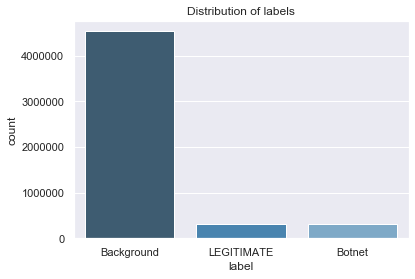

In [6]:
sns.countplot(x="label", data=data_df, palette="Blues_d")
plt.title("Distribution of labels")
plt.show()

We can see that there is a high imbalance, if we consider the background data

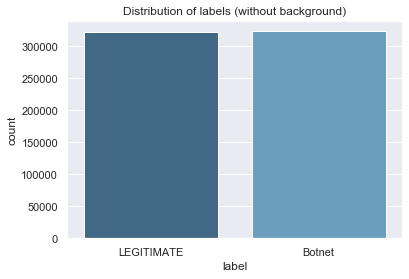

In [7]:
sns.countplot(x="label", data=data_df[data_df['label'] != 'Background'], palette="Blues_d")
plt.title("Distribution of labels (without background)")
plt.show()

Between Legitimate and Botnet there is a nice balance

# Attention: for now, I removed background information. Let's see what they see on Mattermost

In [8]:
data_df = data_df[data_df['label'] != 'Background']
data_df.reset_index(drop=True, inplace=True)
data_df.shape

(645358, 13)

In [9]:
data_df.dtypes

start_date    datetime64[ns]
duration             float64
protocol              object
src_addr              object
dst_addr              object
flags                 object
tos                    int64
packets                int64
bytes                  int64
flows                  int64
label                 object
src_port               int64
dst_port               int64
dtype: object

Let's drop some columns which we do not use for the classification (we do not consider sequences)

In [17]:
new_df = data_df.drop(columns=['start_date', 'tos', 'packets', 'flows'])
new_df.head()

,duration,protocol,src_addr,dst_addr,flags,bytes,label,src_port,dst_port
0,4.985,TCP,147.32.80.13,147.32.85.88,PA_,86277,LEGITIMATE,80,56949
1,0.000,TCP,147.32.86.110,74.125.232.214,A_,66,LEGITIMATE,48102,443
2,4.921,TCP,147.32.85.88,147.32.80.13,A_,3234,LEGITIMATE,56949,80
3,4.742,TCP,147.32.84.59,74.125.108.208,A_,7080,LEGITIMATE,2768,80
4,0.000,TCP,147.32.84.59,74.125.232.215,A_,60,LEGITIMATE,56058,443


### Let's do some analysis to select which features to use

Processing feature 'duration'


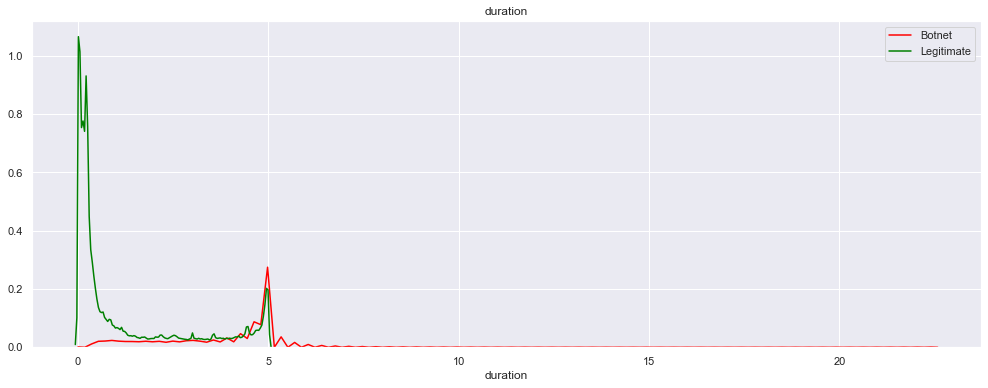

Processing feature 'protocol'


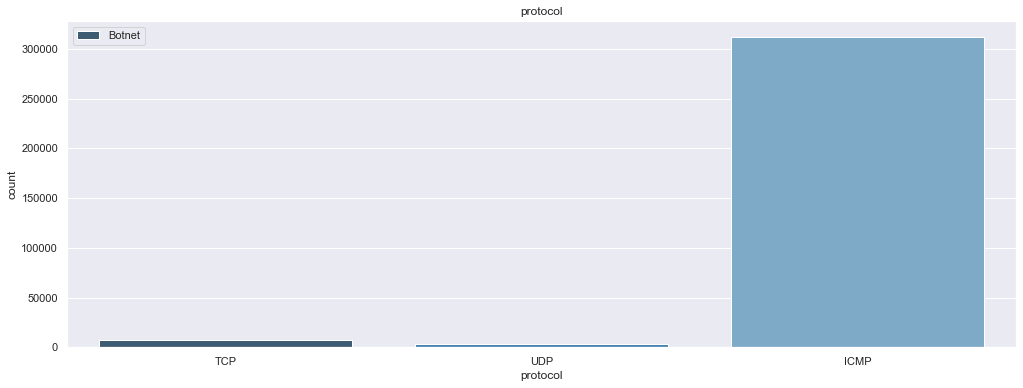

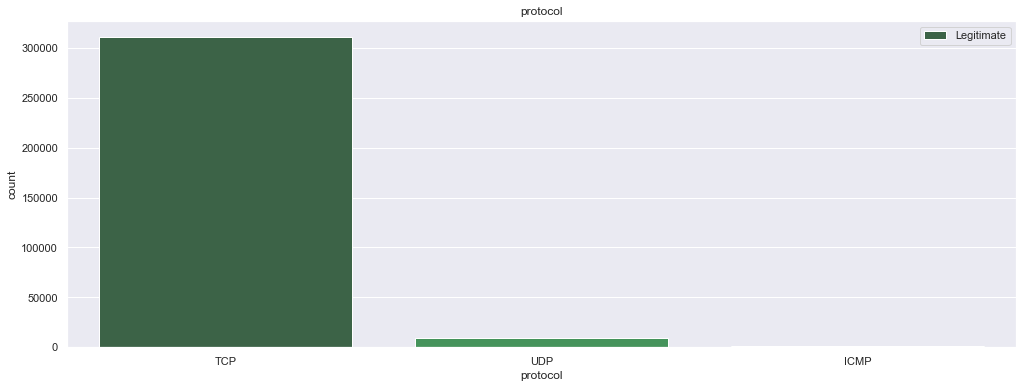

Processing feature 'flags'


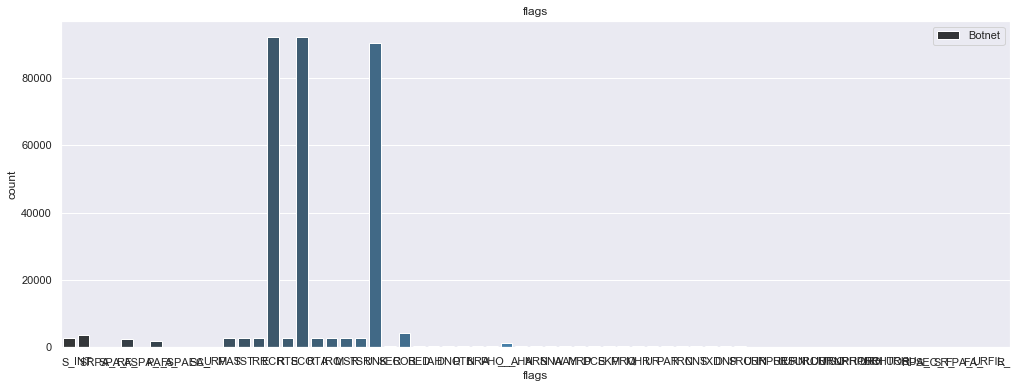

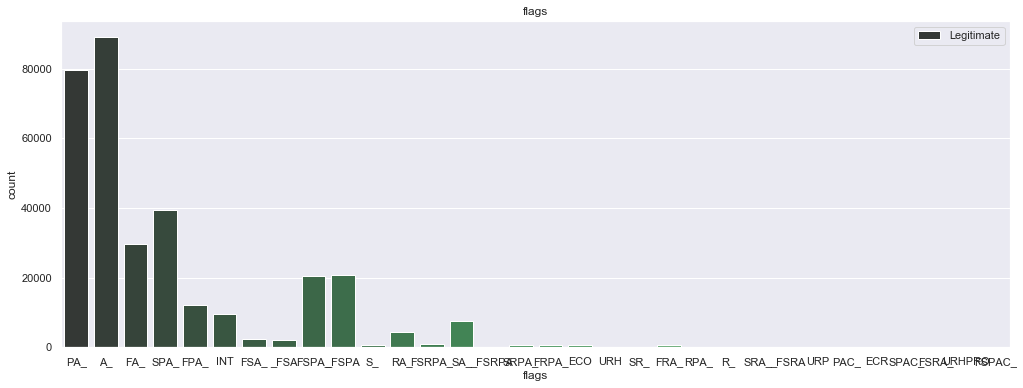

Processing feature 'bytes'


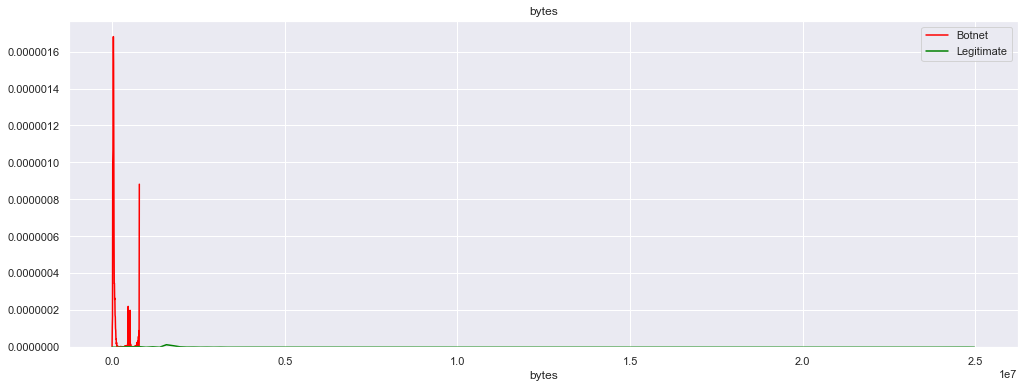

Processing feature 'src_port'


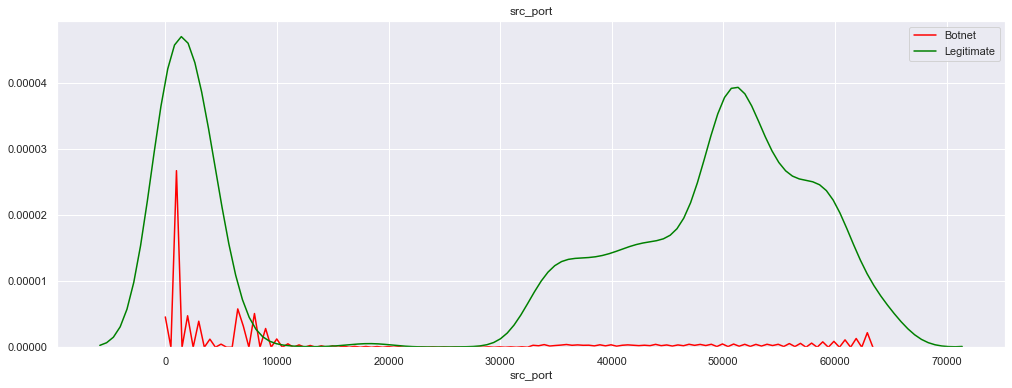

Processing feature 'dst_port'


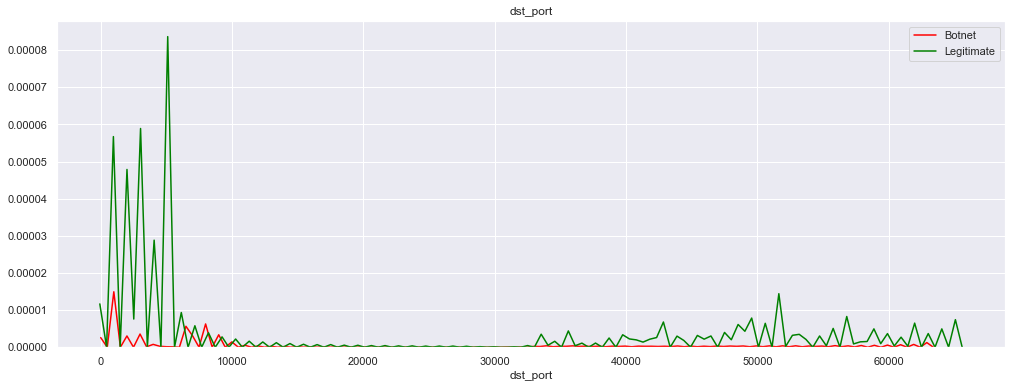

In [19]:
categorical = ['protocol', 'flags']
for feature in new_df.columns:
    if feature in ['label', 'src_addr', 'dst_addr']:
        continue
        
    print(f"Processing feature '{feature}'")
    botnet = new_df[new_df.label == 'Botnet']
    legitimate = new_df[new_df.label == 'LEGITIMATE']
    
    
    if feature not in categorical:  
        plt.figure(figsize=(17,6))
        sns.distplot(botnet[feature], color='Red', hist=False, label='Botnet')
        sns.distplot(legitimate[feature], color='Green', hist=False, label='Legitimate')
        plt.legend()
        plt.title(feature)
        plt.show()
        
    else:
        plt.figure(figsize=(17,6))
        sns.countplot(x=feature, data=botnet, palette="Blues_d", label='Botnet')
        plt.legend()
        plt.title(feature)
        plt.show()
        
        plt.figure(figsize=(17,6))
        sns.countplot(x=feature, data=legitimate, palette="Greens_d", label='Legitimate')
        plt.legend()
        plt.title(feature)
        plt.show()
        

    

First of all, let's one-hot encode the categorical features. Categorical variables are: 'protocol' and 'flags'.

In [76]:
dummy_df = pd.get_dummies(new_df, columns = ['protocol', 'flags'], prefix = ['prot', 'flag'])

dummy_df.head()

,duration,src_addr,dst_addr,bytes,label,src_port,dst_port,prot_ICMP,prot_TCP,prot_UDP,...,flag_URNU,flag_URP,flag_URPRE,flag_URS,flag_WAY,flag__FSA,flag__FSPA,flag__FSRA,flag__FSRPA,flag____
0,4.985,147.32.80.13,147.32.85.88,86277,LEGITIMATE,80,56949,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0.000,147.32.86.110,74.125.232.214,66,LEGITIMATE,48102,443,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,4.921,147.32.85.88,147.32.80.13,3234,LEGITIMATE,56949,80,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4.742,147.32.84.59,74.125.108.208,7080,LEGITIMATE,2768,80,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.000,147.32.84.59,74.125.232.215,60,LEGITIMATE,56058,443,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Classification

In order to evaluate both at the packet and at the host level, we split the data for train and test based on the IPs.

In [212]:
ips_for_train = ['147.32.84.209', '147.32.84.165', '147.32.84.191', '147.32.84.192', '147.32.84.193', '147.32.84.204', '147.32.84.205', '147.32.84.206', '147.32.84.170', '147.32.84.134']
ips_for_test = ['147.32.84.207', '147.32.84.208', '147.32.84.164', '147.32.87.36', '147.32.80.9']

In [213]:
train_data = dummy_df[(dummy_df['src_addr'].isin(ips_for_train)) | (dummy_df['dst_addr'].isin(ips_for_train))]
test_data = dummy_df[(dummy_df['src_addr'].isin(ips_for_test)) | (dummy_df['dst_addr'].isin(ips_for_test))]

In [214]:
print(train_data.shape)
train_data.groupby('label').size()

(289934, 88)


label
Botnet        257334
LEGITIMATE     32600
dtype: int64

In [215]:
print(test_data.shape)
test_data.groupby('label').size()

(90295, 88)


label
Botnet        66351
LEGITIMATE    23944
dtype: int64

In [216]:
257334/32600

7.893680981595092

In [217]:
66107/10910

6.059303391384051

Before we start training, we need to balance the data in the training set.

We need to first split the data in features and labels.

In [218]:
y = train_data['label']
X = train_data.drop(['label', 'src_addr', 'dst_addr'], axis = 1)

y_test = test_data['label']
X_test = test_data.drop(['label', 'src_addr', 'dst_addr'], axis = 1)

In [219]:
y.value_counts()

Botnet        257334
LEGITIMATE     32600
Name: label, dtype: int64

In [220]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X, y)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [221]:
pd.Series(y_resampled).value_counts()

Botnet        32600
LEGITIMATE    32600
dtype: int64

In [222]:
y_resampled = pd.Series(y_resampled).map({
    'LEGITIMATE': 0,
    'Botnet': 1
})

y_test = pd.Series(y_test).map({
    'LEGITIMATE': 0,
    'Botnet': 1
})

Now we can train a classifier.

In [223]:
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)

In [224]:
rf = RandomForestClassifier(n_estimators = 50, random_state = 42)
rf.fit(X_resampled, y_resampled)
predictions = pd.Series(rf.predict(X_test), index = y_test.index)

Let's test it on the packets level.

In [225]:
confusion_matrix(y_test, predictions)

array([[23678,   266],
       [   46, 66305]], dtype=int64)

In [226]:
importances = rf.feature_importances_
columns = X_resampled.columns

imp_per_col = list(zip(importances, columns))

sorted_imp_per_col = sorted(imp_per_col, key=lambda tup: tup[0], reverse=True)


sorted_imp_per_col


[(0.2627158221216009, 'src_port'),
 (0.20037739764712992, 'prot_ICMP'),
 (0.12794769554656024, 'dst_port'),
 (0.12709207080001794, 'bytes'),
 (0.10309730334970237, 'prot_TCP'),
 (0.02851547193548368, 'flag_A_'),
 (0.028437511670603235, 'flag_ECO'),
 (0.02039501508058271, 'flag_ECR'),
 (0.018130384834810016, 'flag_UNK'),
 (0.016398773753347064, 'prot_UDP'),
 (0.015998289156580556, 'flag_PA_'),
 (0.014037418000176369, 'duration'),
 (0.011733581459249456, 'flag_INT'),
 (0.010610468372210935, 'flag_S_'),
 (0.005279630629542271, 'flag_RA_'),
 (0.0028719488780437593, 'flag__FSA'),
 (0.002357951535396686, 'flag_SPA_'),
 (0.0014632805533769534, 'flag_FA_'),
 (0.00045301166225807305, 'flag_FSPA_'),
 (0.00037460036228932484, 'flag_FSA_'),
 (0.0003569595034600149, 'flag_MAS'),
 (0.0002611641098585186, 'flag_TSR'),
 (0.0002372615283871908, 'flag_ROB'),
 (0.00019017108599311616, 'flag_SA_'),
 (0.00018735097970444572, 'flag_IRR'),
 (0.00014843343020647982, 'flag_SRPA_'),
 (9.925134503784822e-05, 'fl

Let's test at the hosts level.

In [227]:
prediction_ips = dummy_df.loc[predictions.index][['src_addr', 'dst_addr']]
prediciton_df = pd.concat([predictions, prediction_ips], axis = 1)
prediciton_df.head()

,0,src_addr,dst_addr
5,0,147.32.84.164,195.24.232.164
20,0,147.32.84.164,94.127.76.194
25,0,147.32.84.164,74.125.232.215
53,0,147.32.84.164,74.125.232.197
55,0,147.32.84.164,209.85.149.138


Prediction using majority voting.

In [232]:
test_infected_ips = ['147.32.84.207', '147.32.84.208']
test_normal_ips = ['147.32.84.164', '147.32.87.36', '147.32.80.9']

tp = 0
tn = 0
fp = 0
fn = 0


for ip in ips_for_test:
    pred_host = prediciton_df[(prediciton_df['src_addr'] == ip) | (prediciton_df['dst_addr'] == ip)][0]
    maj_voting_pred = pred_host.value_counts().argmax()
    if maj_voting_pred == 1 and ip in test_infected_ips:
        tp += 1
    elif maj_voting_pred == 0 and ip in test_normal_ips:
        tn += 1
    elif maj_voting_pred == 1 and ip in test_normal_ips:
        fp += 1
    else:
        fn +=1
            
print(f"TP: {tp}\nTN: {tn}\nFP: {fp}\nFN: {fn}")

TP: 2
TN: 3
FP: 0
FN: 0


C:\Users\biby_\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  if sys.path[0] == '':


Prediction based on classifying a host as Botnet if at least one packet is classified as malicious.

In [239]:
test_infected_ips = ['147.32.84.207', '147.32.84.208']
test_normal_ips = ['147.32.84.164', '147.32.87.36', '147.32.80.9']

tp = 0
tn = 0
fp = 0
fn = 0


for ip in ips_for_test:
    pred_host = prediciton_df[(prediciton_df['src_addr'] == ip) | (prediciton_df['dst_addr'] == ip)][0]
    
    if 1 in pred_host.values:
        maj_voting_pred = 1
    else:
        maj_voting_pred = 0
        
    if maj_voting_pred == 1 and ip in test_infected_ips:
        tp += 1
    elif maj_voting_pred == 0 and ip in test_normal_ips:
        tn += 1
    elif maj_voting_pred == 1 and ip in test_normal_ips:
        fp += 1
    elif maj_voting_pred == 0 and ip in test_infected_ips:
        fn +=1
    else:
        print('SOMETHING WRONG')
            
print(f"TP: {tp}\nTN: {tn}\nFP: {fp}\nFN: {fn}")

TP: 2
TN: 0
FP: 3
FN: 0
